In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10  # This automatically handles the dataset splitting in memory
import matplotlib.pyplot as plt
import numpy as np


class InpaintingModel(nn.Module):
    def __init__(self):
        super(InpaintingModel, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            # 3 channel image, 64 feature maps, stride by 2 (halving the image)
            # 64 -> 128 -> 256 (outputting more feature maps, 
            # but reducing spatial dimensions so that the layer would capture more complex patterns and structure)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 16x16 -> 32x32
            nn.Sigmoid()  # Output normalized to [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [2]:
# Mask Function to randomly make a mask from the image
def mask_image(img, mask_size):
    masked_img = img.clone()  # clone so we preserve original image
    _, h, w = img.shape
    y = np.random.randint(0, h - mask_size)
    x = np.random.randint(0, w - mask_size)
    masked_img[:, y:y + mask_size, x:x + mask_size] = 0
    return masked_img, (x, y, mask_size)

In [3]:
# transformation + data augmentation for training 
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()  # Convert image to a PyTorch tensor
])


test_transform = transforms.Compose([
    transforms.ToTensor()  # Convert image to a PyTorch tensor
])

full_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Split into train and test sets (8:2)
train_size = int(0.8 * len(full_dataset)) 
test_size = len(full_dataset) - train_size 
trainset, testset = random_split(full_dataset, [train_size, test_size])

testset.dataset.transform = test_transform

# DataLoaders for training and testing sets
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

print("Dataset separation and Data Loader Finished.")

Files already downloaded and verified
Dataset separation and Data Loader Finished.


In [4]:

model = InpaintingModel()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# METHOD 1. getting accuracy by comparing entire pixel values between ground truth and inpainted image
def evaluate_accuracy(testloader, model):
    model.eval()
    total_pixel_val_difference = 0
    total_max_pixel_difference = 0

    with torch.no_grad(): 
        for inputs, _ in testloader:
            # Directly pass the input images through the model (no masking needed for evaluation)
            outputs = model(inputs)

            for idx, output in enumerate(outputs):
                ground_truth_image = inputs[idx]

                # Ensure pixel values are in the range 0-255 (rescale from 0-1 to 0-255)
                output = output * 255.0
                ground_truth_image = ground_truth_image * 255.0

                # Compute the absolute pixel-wise difference for the entire image
                diff = torch.abs(output - ground_truth_image)

                # Sum all pixel differences for this image
                pixel_difference = torch.sum(diff).item()
                total_pixel_val_difference += pixel_difference
                
                max_pixel_difference = 255 * torch.numel(output)
                total_max_pixel_difference += max_pixel_difference

    # Print the total pixel difference across the entire test set
    accuracy = (1 - (total_pixel_val_difference / total_max_pixel_difference)) * 100
    print(f'accuracy: {accuracy:.2f}')
    return total_pixel_val_difference



In [5]:
# Training loop
epochs = 10
mask_size = 8

for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for i, (inputs, _) in enumerate(trainloader):
        # Randomly mask part of the image
        masked_inputs = torch.stack([mask_image(img, mask_size)[0] for img in inputs])

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(masked_inputs)

        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 batches
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    # Evaluate accuracy after each epoch
    evaluate_accuracy(testloader, model)

print('Finished Training')


Epoch [1/10], Step [100/1250], Loss: 0.0325
Epoch [1/10], Step [200/1250], Loss: 0.0137
Epoch [1/10], Step [300/1250], Loss: 0.0104
Epoch [1/10], Step [400/1250], Loss: 0.0090
Epoch [1/10], Step [500/1250], Loss: 0.0075
Epoch [1/10], Step [600/1250], Loss: 0.0064
Epoch [1/10], Step [700/1250], Loss: 0.0057
Epoch [1/10], Step [800/1250], Loss: 0.0052
Epoch [1/10], Step [900/1250], Loss: 0.0048
Epoch [1/10], Step [1000/1250], Loss: 0.0046
Epoch [1/10], Step [1100/1250], Loss: 0.0045
Epoch [1/10], Step [1200/1250], Loss: 0.0043
accuracy: 95.92
Epoch [2/10], Step [100/1250], Loss: 0.0042
Epoch [2/10], Step [200/1250], Loss: 0.0039
Epoch [2/10], Step [300/1250], Loss: 0.0039
Epoch [2/10], Step [400/1250], Loss: 0.0038
Epoch [2/10], Step [500/1250], Loss: 0.0037
Epoch [2/10], Step [600/1250], Loss: 0.0036
Epoch [2/10], Step [700/1250], Loss: 0.0036
Epoch [2/10], Step [800/1250], Loss: 0.0035
Epoch [2/10], Step [900/1250], Loss: 0.0034
Epoch [2/10], Step [1000/1250], Loss: 0.0034
Epoch [2/10]

In [6]:
# Save trained model
torch.save(model.state_dict(), 'inpainting_model_v2.pth')

print("finished saving model.")

finished saving model.


# Trying with more images

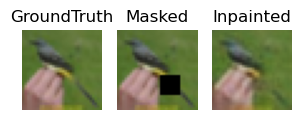

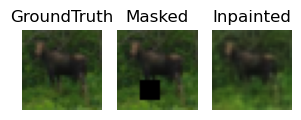

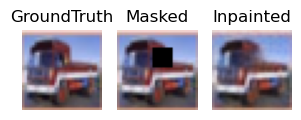

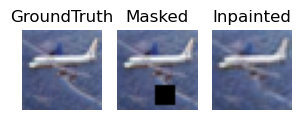

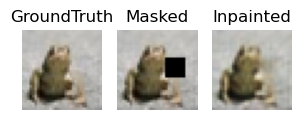

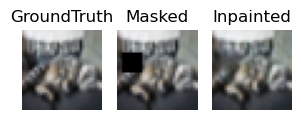

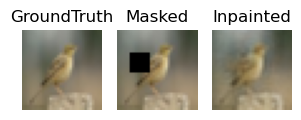

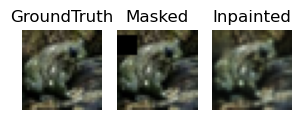

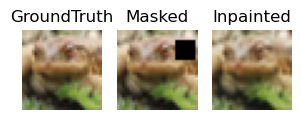

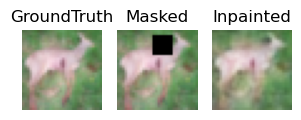

In [7]:
# Set model to evaluation mode
model.eval()

# Example of showing the ground truth, masked, and predicted inpainted images for 10 images
dataiter = iter(testloader)  # Use testloader to visualize unseen data


num_images_to_inpaint = 10
for i in range(num_images_to_inpaint):
    # Get next batch of images and apply mask
    images, _ = next(dataiter)
    masked_images, mask_info = mask_image(images[0], mask_size)
    

    plt.figure(figsize=(3, 3))

    # original ground truth image
    plt.subplot(1, 3, 1)
    plt.imshow(images[0].permute(1, 2, 0))  # Convert tensor to (H, W, C) format for display
    plt.title("GroundTruth")
    plt.axis('off')
    
    # masked image
    plt.subplot(1, 3, 2)
    plt.imshow(masked_images.permute(1, 2, 0))
    plt.title("Masked")
    plt.axis('off')
    
    # Reconstruct masked image using the model
    with torch.no_grad():
        reconstructed = model(masked_images.unsqueeze(0))  # Add batch dimension for model input

    # Show the inpainted (reconstructed) image
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed.squeeze().permute(1, 2, 0))
    plt.title("Inpainted")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
